In [1]:
import os
os.chdir('..') # this resolves ImportError: attempted relative import with no known parent package
# import sys
# parent_dir = os.getcwd()
# sys.path.append(parent_dir)
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from src.processing.data_manipulation import single_metric_dataframes, split_into_video_series
from src.processing.feature_engineering import create_year_month_columns, create_video_counts_columns

In [2]:
raw_data = pd.read_csv("data/processed/json_data_processed.csv")
data = raw_data.copy()
df = pd.DataFrame(data)
df.head()

,videoID,publishedAt,channelId,title,description,channelTitle,tags,viewCount,likeCount,favoriteCount,commentCount,duration_timedelta,duration_hhmmss
0,uGtc9Bu9Txk,2020-12-31T23:00:10Z,UCArk93C2pbOvkv6jWz-3kAg,🍾 FORD KIERNAN HOGMANAY SPECIAL! | Open Goal,SUBSCRIBE to Open Goal - https://bit.ly/2QGY26...,Open Goal,"['open goal', 'si ferry', 'still game', 'jack ...",205682,2286,0,112,0 days 01:21:55,01:21:55
1,vAGmV-mRRT0,2020-12-24T07:00:08Z,UCArk93C2pbOvkv6jWz-3kAg,CHRISTMAS EVE SPECIAL | Right in the Coupon w/...,SUBSCRIBE to Open Goal - https://bit.ly/2QGY26...,Open Goal,"['open goal', 'si ferry', 'betting', 'slaney',...",63357,742,0,30,0 days 00:44:31,00:44:31
2,m54LPZSlStQ,2020-12-22T17:00:20Z,UCArk93C2pbOvkv6jWz-3kAg,EPIC CUP FINAL REVIEW | Keeping the Ball on th...,SUBSCRIBE to Open Goal - https://bit.ly/2QGY26...,Open Goal,"['open goal', 'si ferry', 'celtic vs hearts', ...",85262,976,0,63,0 days 01:06:12,01:06:12
3,1RcFj1Sfs58,2020-12-21T17:00:03Z,UCArk93C2pbOvkv6jWz-3kAg,JAMIE CARRAGHER | Open Goal Meets...,SUBSCRIBE to Open Goal - https://bit.ly/2QGY26...,Open Goal,"['open goal', 'si ferry', 'Jamie Carragher', '...",855101,4966,0,661,0 days 02:22:14,02:22:14
4,MaJhyEr6csQ,2020-12-17T17:25:28Z,UCArk93C2pbOvkv6jWz-3kAg,CELTIC v HEARTS & ST MIRREN END RANGERS UNBEAT...,SUBSCRIBE to Open Goal - https://bit.ly/2QGY26...,Open Goal,"['open goal', 'si ferry', 'celtic v hearts', '...",64383,659,0,49,0 days 00:45:40,00:45:40


In [3]:
df = create_year_month_columns(df)
df = create_video_counts_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   videoID               739 non-null    object             
 1   publishedAt           739 non-null    datetime64[ns, UTC]
 2   publishedAtYear       739 non-null    object             
 3   publishedAtMonth      739 non-null    object             
 4   publishedAtYearMonth  739 non-null    object             
 5   channelTitle          739 non-null    object             
 6   channelId             739 non-null    object             
 7   title                 739 non-null    object             
 8   description           734 non-null    object             
 9   duration_timedelta    739 non-null    object             
 10  duration_hhmmss       739 non-null    object             
 11  tags                  739 non-null    object             
 12  viewCoun

# Prepare dataframe for viz

In [4]:
def prep_df_for_visualisation(df):
    """Groups the dataframe so it is structured in a way so that it can be passed
    to the visualisation functions for quick and easy visualisation.

    Parameters
    ----------
    df : pandas dataframe
        A pandas dataframe that contains the following columns:
            publishedAtYearMonth, publishedAtYear, publishedAtMonth, videoCountMonth, 
            videoCountYear, viewCount, likeCount, commentCount.

    Returns
    -------
    df_grouped : pandas dataframe
        The input dataframe grouped and ready for visualisation.

    Notes
    ------
    
    
    """
    # group the views, likes and comment numbers by year and month
    df_group = (
        df.groupby(by=[df['publishedAtYearMonth'], df['publishedAtYear'], df['publishedAtMonth'], 
                       df['videoCountMonth'], df['videoCountYear']])[
        ['viewCount', 'likeCount', 'commentCount']
        ]
        .sum()
        .astype(int)
        .sort_values(["publishedAtYear", "publishedAtMonth"], ascending=True)
        )
    
    df_group.reset_index(inplace=True)
    
    # change column order
    df_group = df_group[['publishedAtYearMonth', 'publishedAtYear', 'publishedAtMonth',
                 'viewCount', 'likeCount', 'commentCount',
                 'videoCountMonth', 'videoCountYear']]

    return df_group


# Visualise the views over time

In [8]:
# define a function that visualises the volume of a metric over time, given a dataframe and a metric name as input
def viz_line_chart(df, metric, chart_title):
    """Returns a line chart given a dataframe and metric.

    Parameters
    -----------
    df : pandas dataframe
        A grouped dataframe created by the `prep_df_for_visualisation` function.

    metric : string
        Name of the metric we want to visualise.

    chart_title : string
        Title for the graph.

    Returns
    -------
    fig : plotly line chart
        A line chart created with plotly.

    Notes
    ------    
    
    """

    fig = px.line(df, 
              x=df["publishedAtYearMonth"], 
              y=f"{metric}",
              # color="publishedAtYear",
              # line_group="publishedAtYear",
              title=f"{chart_title}",
              line_shape='spline',
              labels={"publishedAtYearMonth": "",
                      "viewCount": "Views", 
                      "likeCount": "Likes", 
                      "commentCount": "Comments",
                      # "videoCountMonth": "No. of videos in month",
                      # "videoCountYear": "No. of videos in year"
                     },
              # hover_name='publishedAtYearMonth',
              hover_data=["viewCount", "likeCount", "commentCount",
                          # "videoCountMonth", "videoCountYear" 
                         ],
              template='plotly_white',
              )
    
    
    return fig.show()

# Video counts viz

In [9]:
# define a function that visualises the volume of a metric over time, given a dataframe and a metric name as input
def viz_video_counts(df, chart_title):
    """Returns a bar chart displaying the number of videos released in each month.

    Parameters
    -----------
    df : pandas dataframe
        A grouped dataframe created by the `prep_df_for_visualisation` function.

    title : string
        The title of the bar chart.

    Returns
    -------
    fig : plotly line chart
        A line chart created with plotly that displays the number of videos released per month.

    Notes
    ------    
    
    """
    
    fig = px.bar(df, 
                  x=df["publishedAtYearMonth"], 
                  y=df["videoCountMonth"],
                  labels={"publishedAtYearMonth": "", 
                          "videoCountMonth": "No. of videos in month",
                          "videoCountYear": "No. of videos in year"
                         },
                 text=df_group['videoCountMonth'],
                 title=f"{chart_title}",
                  hover_data=['videoCountMonth', 'videoCountYear'],
                 template='plotly_white'
                 )
    
    
    fig.show()

In [10]:
df_group = prep_df_for_visualisation(df)
df_group.head()

,publishedAtYearMonth,publishedAtYear,publishedAtMonth,viewCount,likeCount,commentCount,videoCountMonth,videoCountYear
0,2017-05,2017,05,8709,37,2,1,57
1,2017-06,2017,06,767417,2577,87,21,57
2,2017-07,2017,07,372375,1610,64,3,57
3,2017-08,2017,08,373218,1793,80,7,57
4,2017-09,2017,09,172559,1152,37,5,57


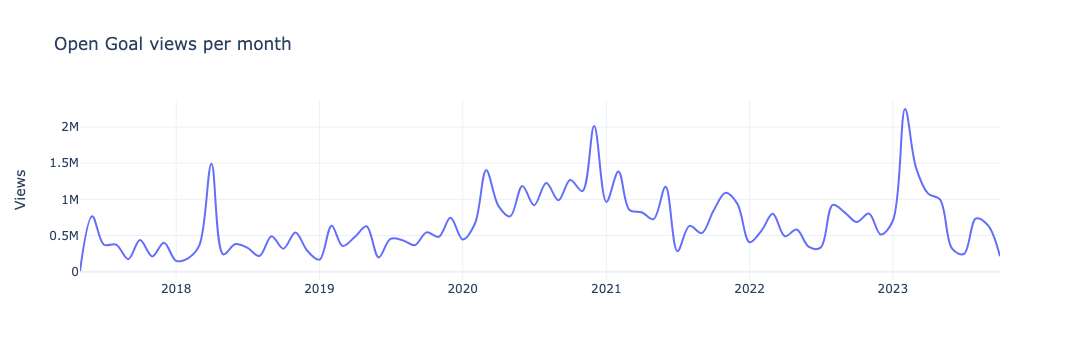

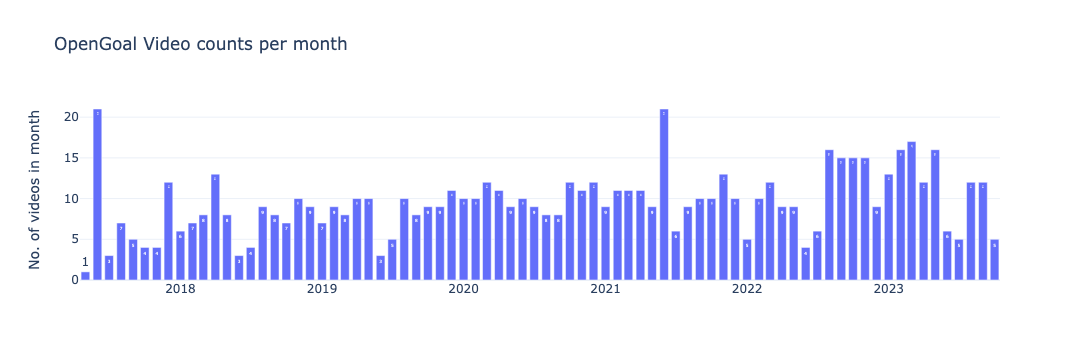

In [13]:
viz_line_chart(df_group, "viewCount", "Open Goal views per month")
viz_video_counts(df_group, "OpenGoal Video counts per month")